In [1]:
import os
import daal4py as d4p
import time
import warnings
# import modin.pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

read csv took: 0.21 s
fill missing value took: 0.08 s


<Axes: >

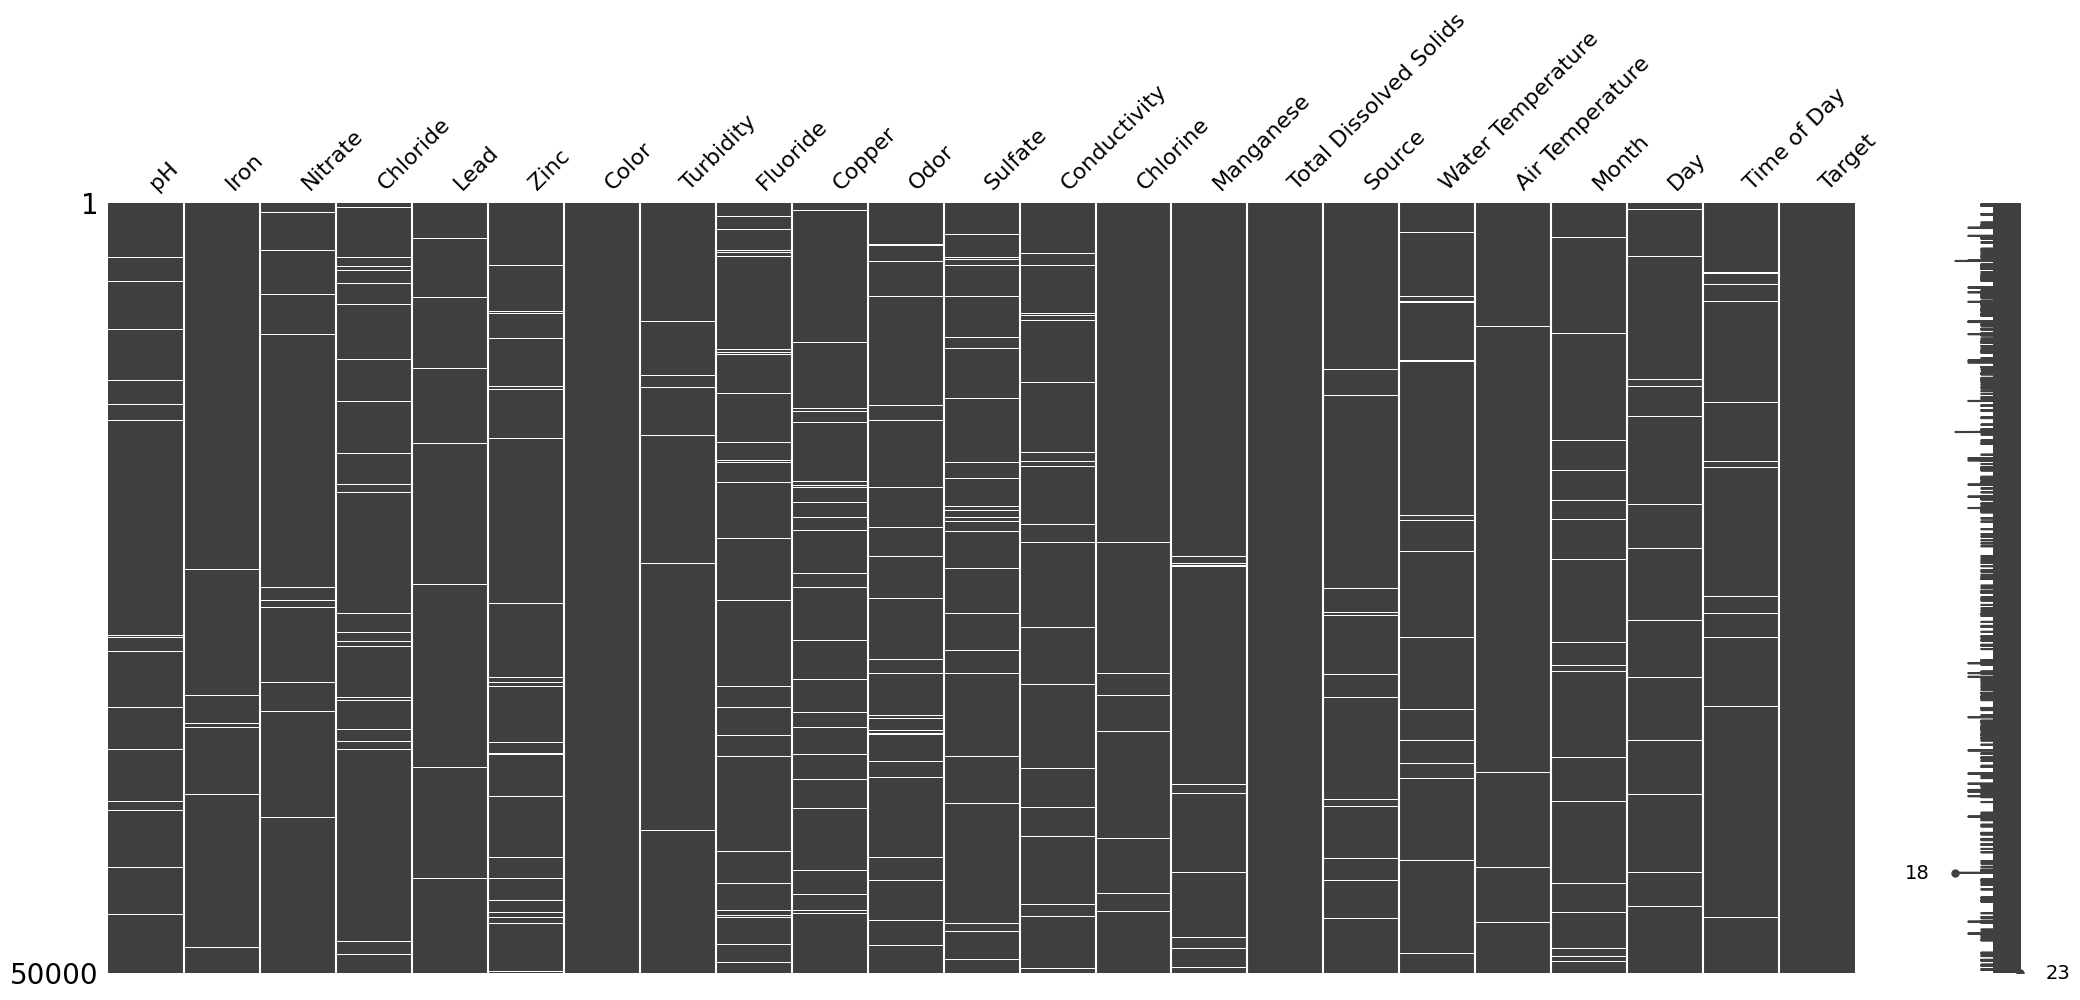

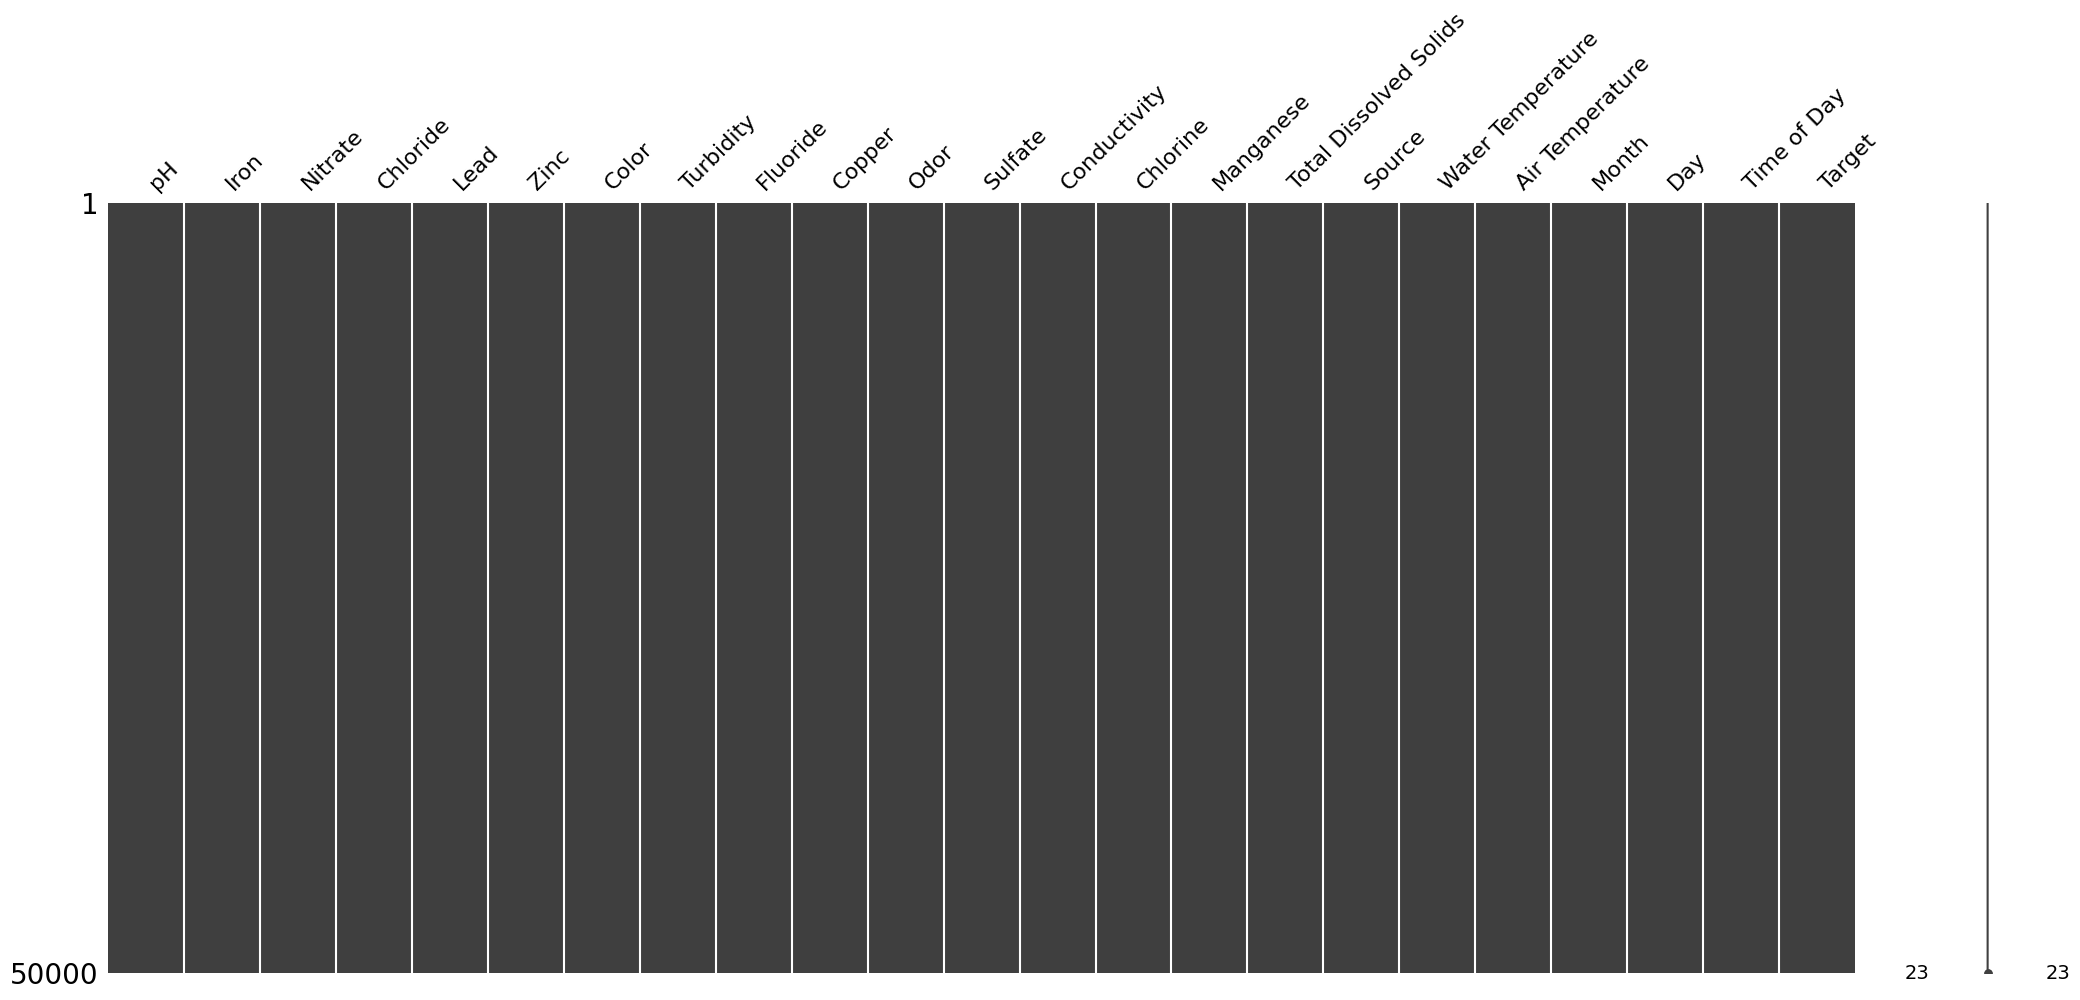

In [2]:
start_read = time.time()
data = pd.read_csv("dataset.csv")
# data = pd.read_csv("50k_dataset.csv")
print("read csv took: {:.2f} s".format(time.time() - start_read))

data.drop(['Index'], inplace=True, axis=1)

# display missing columns
msno.matrix(data)
# handle missing values
start_fill = time.time()
for column in data.columns:
    data[column].interpolate(method='linear', inplace=True)
    if data[column].dtype == 'object':
        mode = data[column].mode().iloc[0]
        data[column].fillna(mode, inplace=True)
    else:
        median = data[column].median()
        data[column].fillna(median, inplace=True)

end_fill = time.time()
print("fill missing value took: {:.2f} s".format(end_fill - start_fill))
msno.matrix(data)

In [3]:
# handle outliers
# numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# for col in numeric_cols:
#     # Calculate 1st and 99th percentiles
#     lower, upper = np.percentile(data[col], [1, 99])
#     data.loc[data[col] < lower, col] = lower
#     data.loc[data[col] > upper, col] = upper

# drop duplicated rows
data = data.drop_duplicates()

# check data
missing = data.isna().sum().sum()
duplicates = data.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

display(data.head())


There are 0 missing values in the data.
There are 0 duplicate records in the data.


pH      Iron    Nitrate    Chloride           Lead      Zinc  \
0  8.363202  0.026002  13.279366  224.654964   3.294790e-98  3.659572   
1  7.180996  0.013533  11.871386  412.075502  8.584804e-122  0.528878   
2  7.192017  0.000233   7.879818  163.046126  3.315243e-285  4.442571   
3  7.111144  0.000199   6.396389  209.512297   1.157846e-41  2.336371   
4  7.392138  0.000005   6.080465  127.739585  7.611868e-104  1.637140   

            Color  Turbidity  Fluoride    Copper  ...  Chlorine     Manganese  \
0    Light Yellow   2.928357  0.208108  3.102599  ...  2.809410  3.007019e-04   
1  Near Colorless   0.430281  0.663251  0.034603  ...  4.244976  2.892038e-01   
2          Yellow   0.000043  1.085084  0.719717  ...  2.754725  2.892038e-01   
3  Near Colorless   0.004361  0.794863  0.950165  ...  3.494851  3.488892e-07   
4  Near Colorless   0.529798  0.213287  0.398200  ...  2.811408  1.707332e-03   

   Total Dissolved Solids     Source  Water Temperature  Air Temperature  \
0               93.615788      River          15.288683        59.380597   
1              166.189438  Reservoir          24.280234        35.031716   
2              462.827569     Ground           8.561498        50.030080   
3              397.995515     Ground          21.524377        68.570551   
4              220.944741  Reservoir          10.799109        60.586970   

      Month   Day  Time of Day Target  
0       May   2.0          5.0      1  
1      July  10.0         13.0      1  
2   January   2.0          7.0      1  
3  December  27.0         19.0      0  
4   January  17.0         16.0      0  

[5 rows x 23 columns]

['Light Yellow' 'Near Colorless' 'Yellow' 'Faint Yellow' 'Colorless']


In [4]:
# transform `Month` to number
month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
data['Month'] = data['Month'].map(month_dict)

# convert air temperature from °F to°C
data['Air Temperature'] = (data['Air Temperature'] - 32) * 5/9

mapping = {}
discretized_features = ['Conductivity', 'Source', 'Color', 'pH', 'Turbidity', 'Odor', 'Month', 'Day', 'Time of Day']
labels_dict = {
    'Conductivity': ['Low', 'Medium', 'High'],
    'Color': ['Colorless', 'Near Colorless', 'Faint Yellow', 'Light Yellow', 'Yellow'],
    'pH': ['Acidic', 'Neutral', 'Alkaline'],
    'Turbidity': ['Very Clear', 'Clear', 'Slightly Turbid', 'Turbid', 'Very Turbid'],
    'Odor': ['No Odor', 'Slight Odor', 'Noticeable Odor', 'Strong Odor'],
    'Month': ['Q1', 'Q2', 'Q3', 'Q4'],
    'Day': ['Beginning', 'Middle', 'End'],
    'Time of Day': ['Night', 'Morning', 'Afternoon', 'Evening'],
}

# discretize features
data['pH'] = pd.cut(data['pH'], bins=[0, 6.5, 8.5, 14], labels=labels_dict['pH'], include_lowest=True)
data['Turbidity'] = pd.cut(data['Turbidity'], bins=[-np.inf, 1, 2, 3, 4, np.inf], labels=labels_dict['Turbidity'])
data['Odor'] = pd.cut(data['Odor'], bins=[-np.inf, 1, 2, 3, np.inf], labels=labels_dict['Odor'])
data['Conductivity'] = pd.cut(data['Conductivity'], bins=[-np.inf, 300, 500, np.inf], labels=labels_dict['Conductivity'])

data['Month'] = pd.cut(data['Month'], bins=[0, 3, 6, 9, 12], labels=labels_dict['Month'], include_lowest=True)
data['Day'] = pd.cut(data['Day'], bins=[0, 10, 20, 31], labels=labels_dict['Day'], include_lowest=True)
data['Time of Day'] = pd.cut(data['Time of Day'], bins=[0, 6, 12, 18, 24], labels=labels_dict['Time of Day'], include_lowest=True)

# transform labels to numerics
for _, column in enumerate(discretized_features):
    if column in labels_dict:
        labels = labels_dict[column]
        category = pd.Categorical(data[column], categories=labels, ordered=True)
        data[column] = category.codes
        mapping[column] = labels
    else:
        codes, labels = pd.factorize(data[column])
        data[column] = codes
        mapping[column] = labels
    
display(data.head())

pH      Iron    Nitrate    Chloride           Lead      Zinc  Color  \
0   1  0.026002  13.279366  224.654964   3.294790e-98  3.659572      3   
1   1  0.013533  11.871386  412.075502  8.584804e-122  0.528878      1   
2   1  0.000233   7.879818  163.046126  3.315243e-285  4.442571      4   
3   1  0.000199   6.396389  209.512297   1.157846e-41  2.336371      1   
4   1  0.000005   6.080465  127.739585  7.611868e-104  1.637140      1   

   Turbidity  Fluoride    Copper  ...  Chlorine     Manganese  \
0          2  0.208108  3.102599  ...  2.809410  3.007019e-04   
1          0  0.663251  0.034603  ...  4.244976  2.892038e-01   
2          0  1.085084  0.719717  ...  2.754725  2.892038e-01   
3          0  0.794863  0.950165  ...  3.494851  3.488892e-07   
4          0  0.213287  0.398200  ...  2.811408  1.707332e-03   

   Total Dissolved Solids  Source  Water Temperature  Air Temperature  Month  \
0               93.615788       0          15.288683        15.211443      1   
1              166.189438       1          24.280234         1.684287      2   
2              462.827569       2           8.561498        10.016711      0   
3              397.995515       2          21.524377        20.316973      3   
4              220.944741       1          10.799109        15.881650      0   

   Day  Time of Day  Target  
0    0            0       1  
1    0            2       1  
2    0            1       1  
3    2            3       0  
4    1            2       0  

[5 rows x 23 columns]

In [5]:
def display_stats():
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df = data.describe()
    skewness = pd.DataFrame(data.skew(numeric_only=True), columns=['skewness']).T
    kurtosis = pd.DataFrame(data.kurt(numeric_only=True), columns=['kurtosis']).T
    df = pd.concat([df, skewness, kurtosis], axis=0)
    display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))

display_stats()

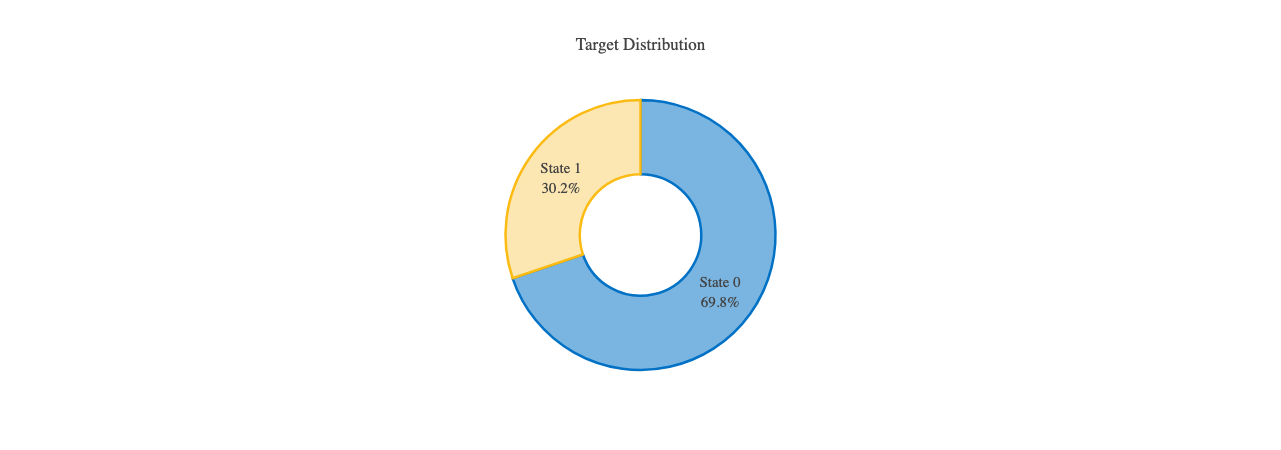

In [6]:
# show target distribution
target=data['Target'].value_counts(normalize=True)
target.rename(index={1:'State 1',0:'State 0'},inplace=True)
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     text=target.index, sort=False, showlegend=False,
                     marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                     hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',width=700,height=450,
                  uniformtext_minsize=15, uniformtext_mode='hide')
fig.show() 

In [7]:
cat_cols,float_cols=[],['Target']
for col in data.columns:
    if data[col].value_counts().count() < 10:
        cat_cols.append(col)
    else:
        float_cols.append(col)
        
print(cat_cols)
print(float_cols)

['pH', 'Color', 'Turbidity', 'Odor', 'Conductivity', 'Source', 'Month', 'Day', 'Time of Day', 'Target']
['Target', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Fluoride', 'Copper', 'Sulfate', 'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature', 'Air Temperature']


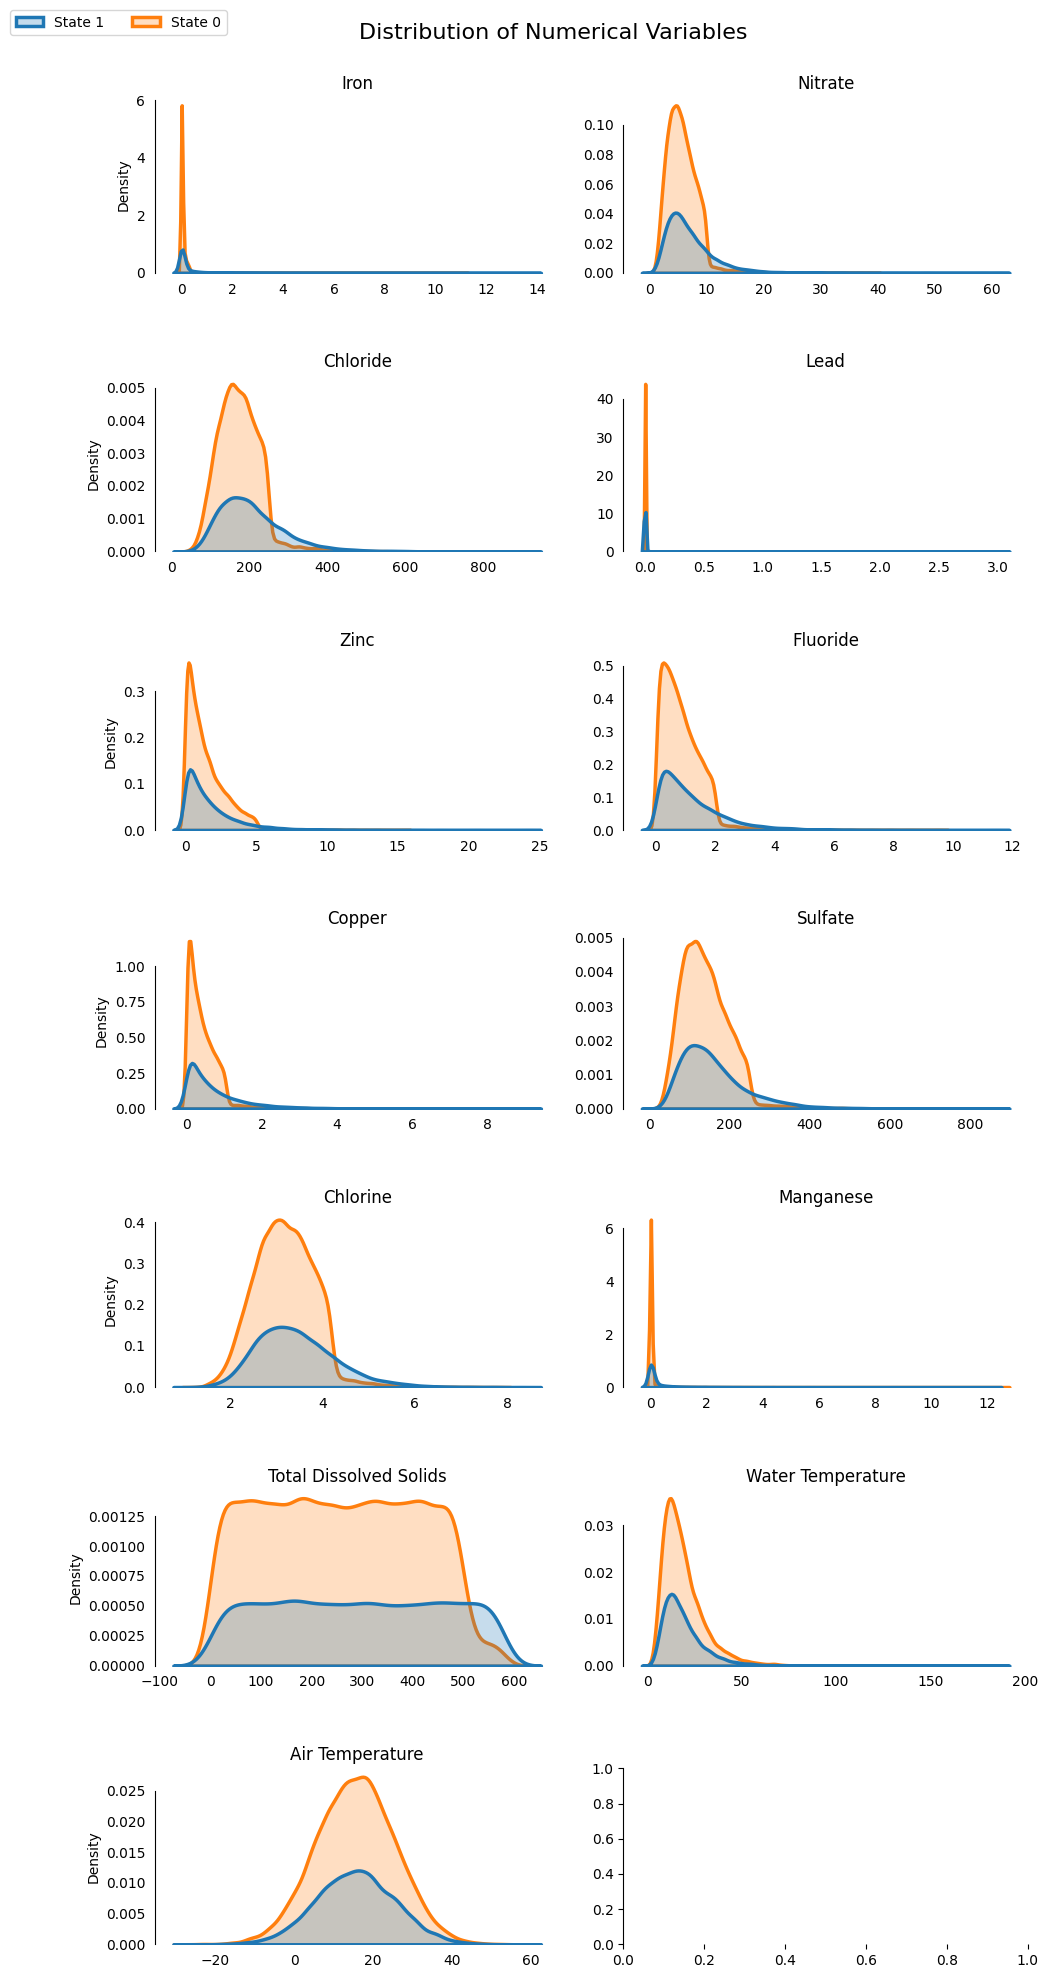

In [8]:
plot_df=data[float_cols]

fig, ax = plt.subplots(7,2, figsize=(10,20))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*7

for i, column in enumerate(plot_df.columns[1:]):
    if (i!=0)&(i%2==0):
        row+=1
    
    sns.kdeplot(
        x=column, hue='Target', hue_order=[1, 0],
        label=['State 1', 'State 0'], data=plot_df,
        fill=True, linewidth=2.5, legend=False, ax=ax[row, col[i]]
    )
    
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout()

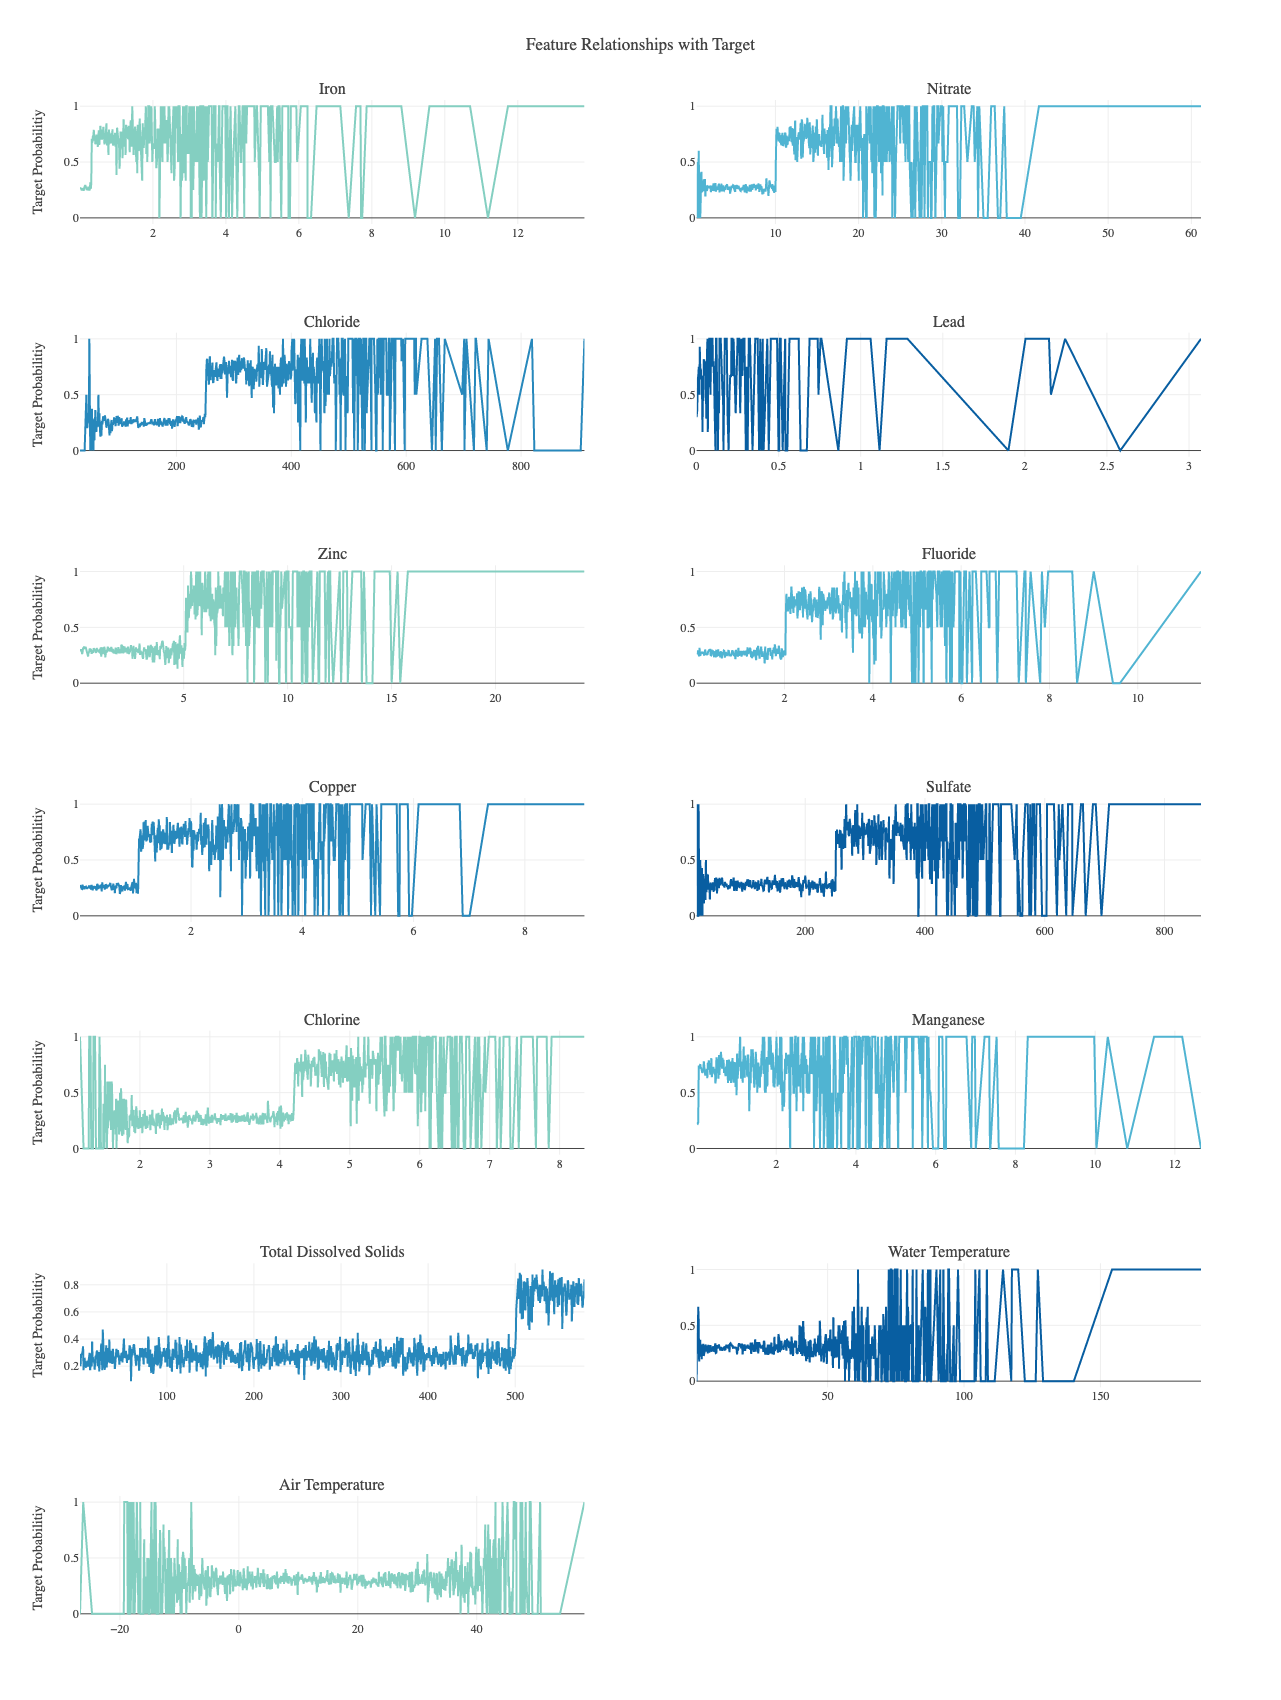

In [9]:
fig=make_subplots(rows=7,cols=2, subplot_titles=float_cols[1:])
col=[1,2]*7
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]

for i, column in enumerate(data[float_cols].columns[1:]):
    if i%2 == 0:
        row += 1
    df = pd.concat([data[column], data['Target']], axis=1)

    df['bins'] = pd.cut(df[column], 1000)
    df['mean'] = df.bins.apply(lambda x: x.mid)

    df = df.groupby('mean')[[column,'Target']].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    
    fig.add_trace(go.Scatter(x=df[column], y=df.Target, name=column,
                             marker_color=pal[i % len(pal)], showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2 == 0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i]) 
fig.update_layout(template=temp, title='Feature Relationships with Target', hovermode="x unified",height=1700,width=1200)
fig.show()

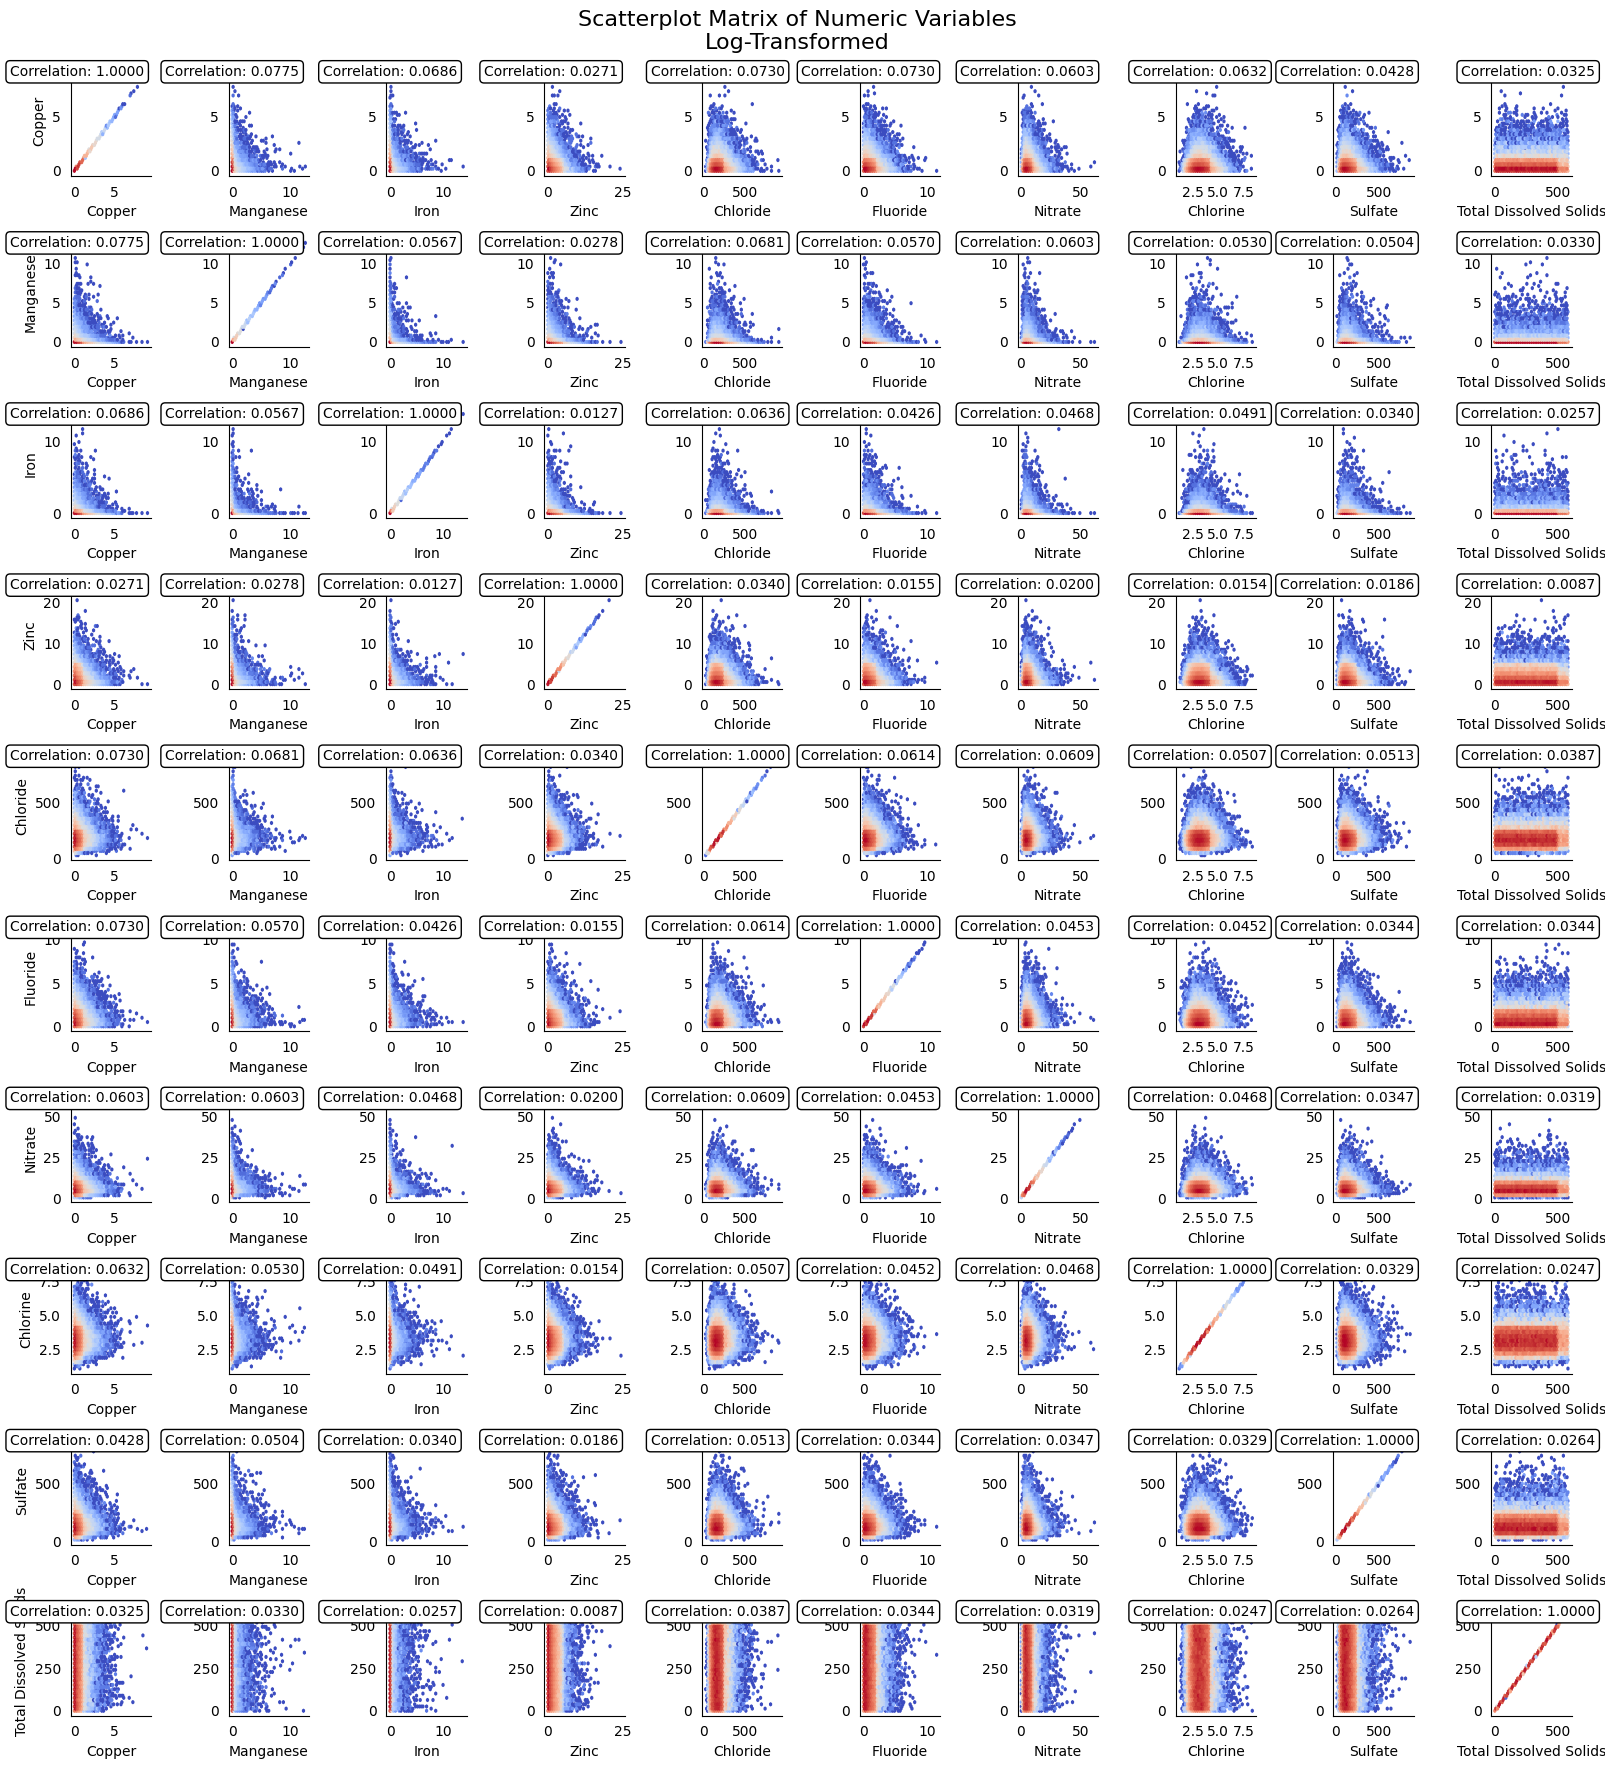

In [10]:
check_cols = ['Copper', 'Manganese', 'Iron', 'Zinc', 'Chloride', 'Fluoride', 'Nitrate', 'Chlorine', 'Sulfate', 'Total Dissolved Solids']

check_cols_len = len(check_cols)

plot_df=data[check_cols]
fig, ax = plt.subplots(check_cols_len, check_cols_len, figsize=(16,18))
fig.suptitle('Scatterplot Matrix of Numeric Variables\nLog-Transformed',fontsize=16)
for i, col in enumerate(check_cols):
    for j, iter_col in enumerate(check_cols):
        ax[i,j].hexbin(x=iter_col, y=col, data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
        ax[i,j].set(xlabel=iter_col, ylabel=(col if j % check_cols_len == 0 else ''))
        ax[i,j].text(plot_df[iter_col].median(), plot_df[col].max(), 
                     'Correlation: {:.4f}'.format(plot_df[[col,iter_col]].corr().iloc[1,0]), 
                   ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax[i,j].tick_params(left=False,bottom=False)    

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In [11]:
fig = make_subplots(rows=5, cols=2, subplot_titles=[c for c in cat_cols if c!='Target'])
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in intel_pal]
row=0
c=[1,2]*5
for i, col in enumerate(c for c in cat_cols if c!='Target'):
    mapping_series = pd.Series(mapping[col])
    if i%2==0:
        row+=1
    df=data.groupby(col)['Target'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=mapping_series[df[df.Target==1][col]],
                         y=df[df.Target==1]['count'],width=.35,
                         marker_color=rgb[1], marker_line=dict(color=intel_pal[1],width=2.5), 
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=mapping_series[df[df.Target==0][col]],
                         y=df[df.Target==0]['count'],width=.35,
                         marker_color=rgb[0], marker_line=dict(color=intel_pal[0],width=2.5),
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%2==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(title="Distributions of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.025,xanchor="right",x=.2),
                  barmode='group',height=800,width=1200)
fig.show()

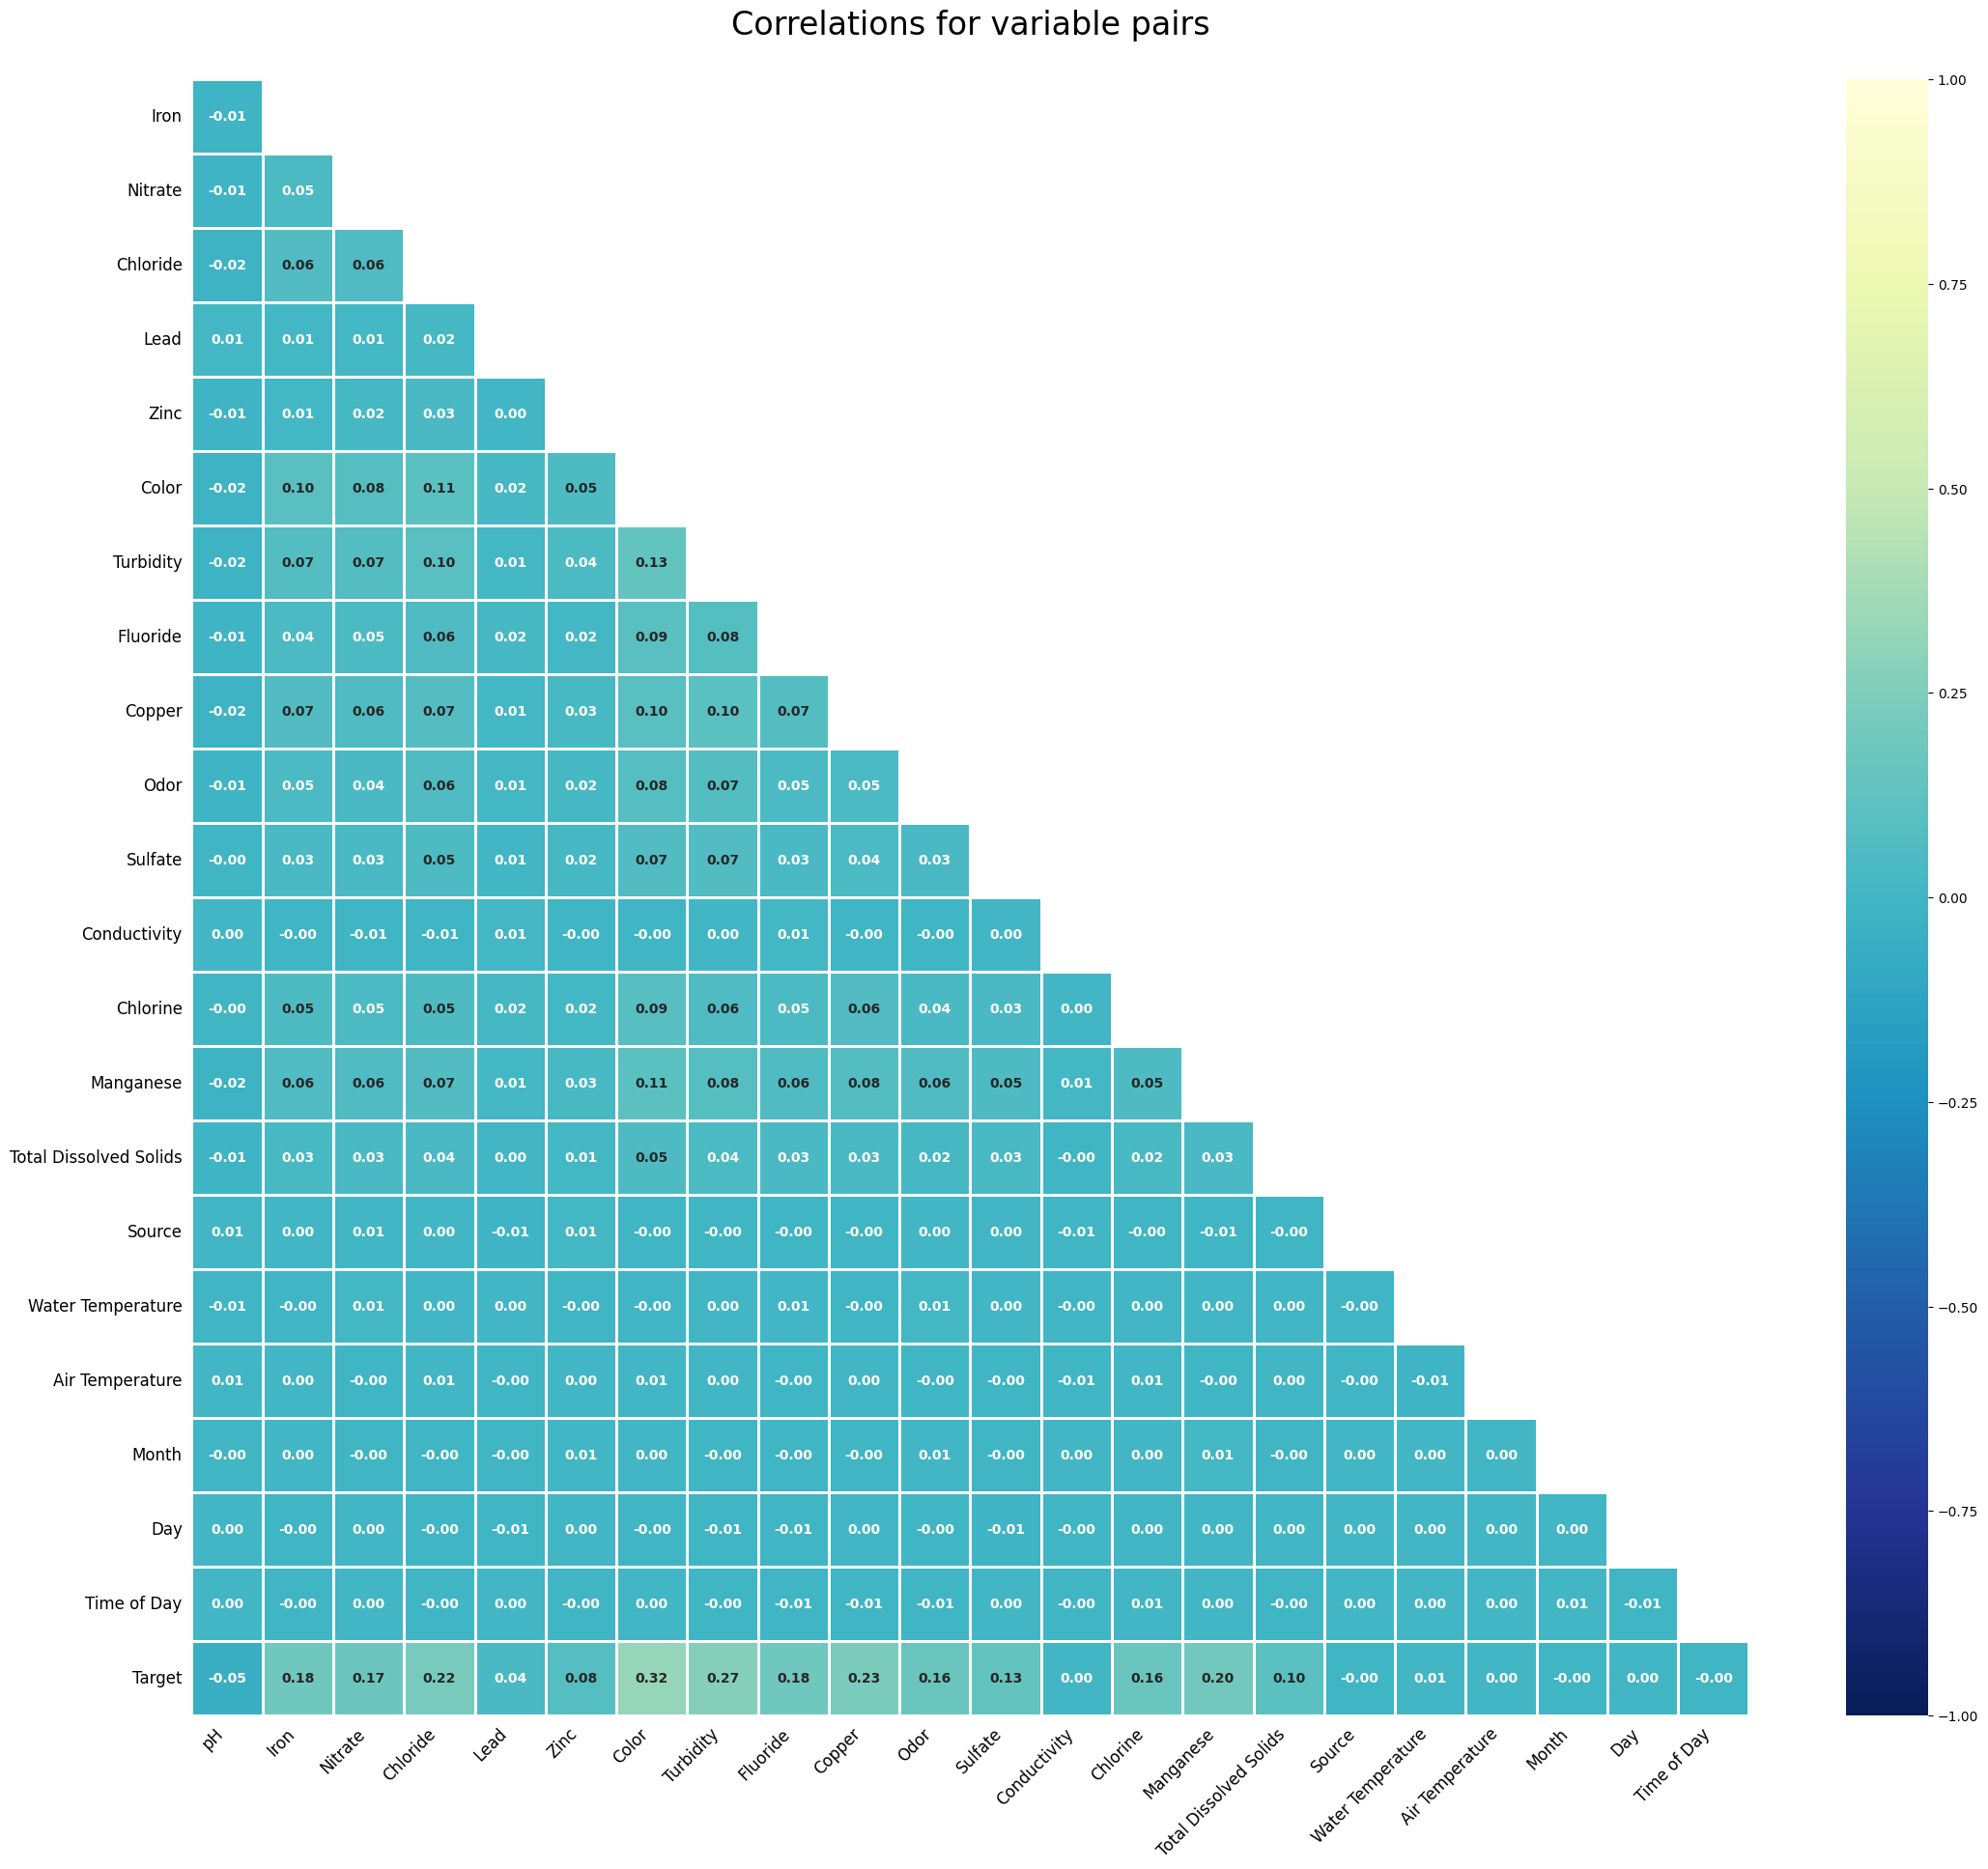

In [12]:
def plot_corr(corr):
    """
    Function to plot bottom left triangle of correlation matrix
    """
    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()
    fig, ax = plt.subplots(figsize=(26,22))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                cmap='YlGnBu_r',lw=2, annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=True)
    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.title('Correlations for variable pairs\n', fontsize=24)
    plt.show()
    
def plot_target_corr(corr, target_col): 
    """
    Function to plot a bar chart of correlations between target and features, sorted in descending order
    """
    corr=corr[target_col].sort_values(ascending=False)[1:]
    pal=sns.color_palette("RdYlBu",37).as_hex()
    pal=[j for i,j in enumerate(pal) if i not in (17,18)]
    rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
    
    fig=go.Figure()
    fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                         marker_line=dict(color=pal,width=2),
                         hovertemplate='%{x} correlation with Target = %{y}',
                         showlegend=False, name=''))
    fig.update_layout(template=temp, title='Feature Correlations with Target', 
                      yaxis_title='Correlation', margin=dict(b=160), xaxis_tickangle=45)
    fig.show()
    
corr=data.corr(numeric_only=False)
plot_corr(corr=corr)
plot_target_corr(corr=corr, target_col='Target')